In [1]:
from matplotlib import pyplot as plt
%matplotlib widget
from eitprocessing.datahandling.continuousdata import ContinuousData
from eitprocessing.datahandling.loading import load_eit_data
from eitprocessing.filters.butterworth_filters import LowPassFilter
from eitprocessing.parameters.eeli import EELI
from eitprocessing.parameters.tidal_impedance_variation import TIV

MINUTE = 60

Load a sequence from file.

In [2]:
sequence = load_eit_data(
    "/Users/juliettefrancovich/Downloads/Draeger_Test_4.bin", vendor="draeger"
)

Filter the global impedance using a low pass filter.

In [4]:
gi = sequence.continuous_data["global_impedance_(raw)"]

filter_params = {
    "sample_frequency": sequence.eit_data["raw"].framerate,
    "cutoff_frequency": 50 / MINUTE,
    "order": 10,
}
filter_ = LowPassFilter(**filter_params)

sequence.continuous_data.add(
    ContinuousData(
        "global_impedance_(lowpass)",
        "Global impedance (low pass filtered)",
        "a.u.",
        "impedance",
        derived_from=[*gi.derived_from, gi],
        parameters={LowPassFilter: filter_params},
        time=gi.time,
        values=filter_.apply_filter(gi.values),
    ),
)

Filter pixel impedance

In [5]:
pixel_impedance = sequence.eit_data["raw"].pixel_impedance

In [6]:
pixel_impedance = sequence.eit_data["raw"].pixel_impedance

filter_params = {
    "sample_frequency": sequence.eit_data["raw"].framerate,
    "cutoff_frequency": 50 / MINUTE,
    "order": 10,
}
filter_ = LowPassFilter(**filter_params)


filtered_pixel_impedance = filter_.apply_filter(pixel_impedance, axis=0)

Select a small portion of the sequence

In [7]:
sequence = sequence.t[40537:40560]

In [9]:
tiv_result_global = TIV().compute_global_parameter(sequence, "global_impedance_(raw)")
tiv_result_pixel = TIV().compute_pixel_parameter(sequence, "raw")

In [18]:
tiv_result_pixel["values"].shape
a = tiv_result_pixel["standard deviation"]

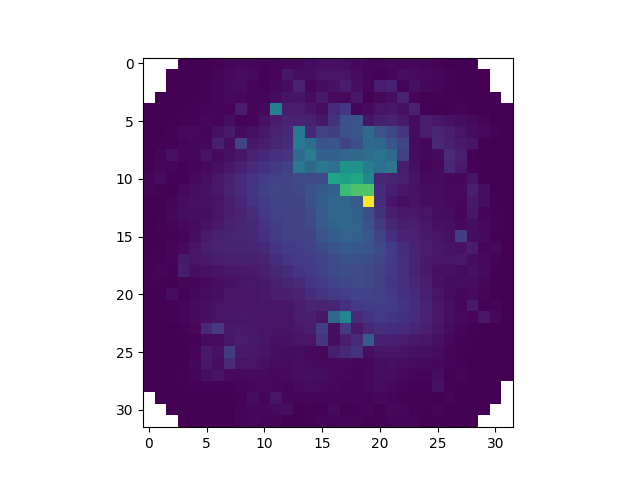

In [19]:
plt.figure()
plt.imshow(a)

Determine the EELI of the selected portion.

In [8]:
eeli_result = EELI().compute_parameter(sequence, "global_impedance_(raw)")
eeli_result_filtered = EELI().compute_parameter(sequence, "global_impedance_(lowpass)")

Plot the results.

Note that the variation in the EELI has decreased after filtering the global impedance. The filter removed the high
frequency noise (mainly cardiac artifacts), which was causing the EELI to fluctuate. 

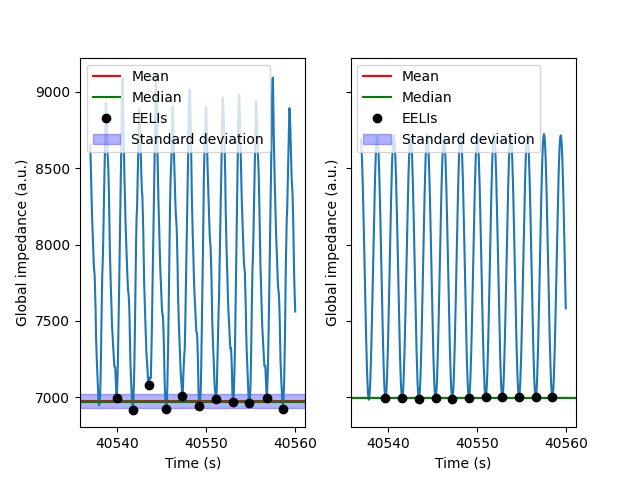

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
for ax, result, gi in zip(
    (ax1, ax2),
    (eeli_result, eeli_result_filtered),
    (
        sequence.continuous_data["global_impedance_(raw)"],
        sequence.continuous_data["global_impedance_(lowpass)"],
    ),
    strict=False,
):
    sd_upper = result["mean"] + result["standard deviation"]
    sd_lower = result["mean"] - result["standard deviation"]

    ax.plot(gi.time, gi.values)
    ax.axhline(result["mean"], color="red", label="Mean")
    ax.axhline(result["median"], color="green", label="Median")
    ax.plot(
        gi.time[result["indices"]],
        result["values"],
        "o",
        color="black",
        label="EELIs",
    )

    xlim = ax.get_xlim()
    ax.fill_between(
        xlim,
        sd_upper,
        sd_lower,
        color="blue",
        alpha=0.3,
        label="Standard deviation",
    )
    ax.set(xlim=xlim, xlabel="Time (s)", ylabel="Global impedance (a.u.)")
    ax.legend()

In [10]:
tiv_result_filtered = TIV().compute_global_parameter(
    sequence, "global_impedance_(lowpass)", tiv_method="expiratory"
)
tiv_result = TIV().compute_global_parameter(
    sequence, "global_impedance_(raw)", tiv_method="mean"
)

In [11]:
tiv_result["values"]

array([1958.20278012, 2134.56650417, 1890.55551103, 2110.88351487,
       1936.98665548, 2040.01032215, 1937.25915385, 1985.72323585,
       2014.02499403, 1956.43593721, 2133.69863064])

In [12]:
from eitprocessing.features.breath_detection import BreathDetection
from dataclasses import dataclass, field

In [13]:
# data = sequence.eit_data["raw"].pixel_impedance

# # bd_kwargs = field(default_factory=dict)
# # bd_kwargs["sample_frequency"] = sequence.eit_data['raw'].framerate
# breath_detection = BreathDetection(sample_frequency=sequence.eit_data["raw"].framerate)
# breaths = breath_detection.find_breaths_3d(data)

# start_indices, middle_indices, end_indices = zip(*breaths, strict=True)
# start_indices = list(start_indices)
# middle_indices = list(middle_indices)
# end_indices = list(end_indices)

In [14]:
from eitprocessing.features.moving_average import MovingAverage
import numpy as np
from typing import NamedTuple
import itertools

In [15]:
sample_frequency = sequence.eit_data["raw"].framerate
minimum_distance = 2 / 3
averaging_window_length = 15
averaging_window_fun = np.blackman
amplitude_cutoff_fraction = 0.25
invalid_data_removal_window_length = 1
invalid_data_removal_percentile = 5
invalid_data_removal_multiplier = 4

In [16]:
data = sequence.eit_data["raw"].pixel_impedance

In [17]:
class _PeakValleyData(NamedTuple):
    peak_indices: np.ndarray
    peak_values: np.ndarray
    valley_indices: np.ndarray
    valley_values: np.ndarray

In [18]:
class Breath(NamedTuple):
    """Indicates the start, middle and end of a single breath."""

    start_index: int
    middle_index: int
    end_index: int

In [19]:
bd = BreathDetection(sample_frequency)

In [20]:
_, rows, cols = data.shape
breaths_array = np.empty((rows, cols), dtype=object)

for row in range(rows):
    for col in range(cols):
        time_series = data[:, row, col]

        window_size = int(sample_frequency * averaging_window_length)
        averager = MovingAverage(window_size=window_size, window_fun=np.bartlett)
        moving_average = averager.apply(time_series)

        peak_indices, peak_values = bd._find_features(time_series, moving_average)
        valley_indices, valley_values = bd._find_features(
            time_series, moving_average, invert=True
        )

        # Skip iteration if no peaks or valleys are detected
        if len(peak_indices) == 0 or len(valley_indices) == 0:
            breaths_array[row, col] = []
            continue

        peak_valley_data = _PeakValleyData(
            peak_indices,
            peak_values,
            valley_indices,
            valley_values,
        )
        peak_valley_data = bd._remove_edge_cases(
            *peak_valley_data, time_series, moving_average
        )
        peak_valley_data = bd._remove_doubles(*peak_valley_data)
        peak_valley_data = bd._remove_low_amplitudes(*peak_valley_data)

        breaths = [
            Breath(int(start), int(middle), int(end))
            for middle, (start, end) in zip(
                peak_valley_data.peak_indices,
                itertools.pairwise(peak_valley_data.valley_indices),
                strict=True,
            )
        ]

        breaths = bd._remove_breaths_around_invalid_data(breaths, time_series)
        breaths_array[row, col] = breaths

In [21]:
breaths_array[13, 13]

[Breath(start_index=19, middle_index=36, end_index=60),
 Breath(start_index=60, middle_index=73, end_index=95),
 Breath(start_index=95, middle_index=110, end_index=136),
 Breath(start_index=136, middle_index=148, end_index=169),
 Breath(start_index=169, middle_index=185, end_index=207),
 Breath(start_index=207, middle_index=224, end_index=245),
 Breath(start_index=245, middle_index=260, end_index=282),
 Breath(start_index=282, middle_index=297, end_index=321),
 Breath(start_index=321, middle_index=334, end_index=356),
 Breath(start_index=356, middle_index=373, end_index=396),
 Breath(start_index=396, middle_index=410, end_index=432)]

In [22]:
start_indices, middle_indices, end_indices = zip(*breaths_array[13, 13], strict=True)

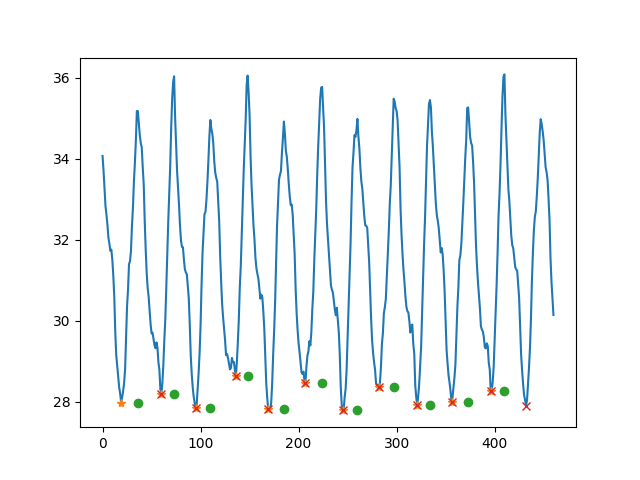

In [23]:
plt.figure()
plt.plot(data[:, 13, 13])
plt.plot(start_indices, data[start_indices, 13, 13], "*")
plt.plot(middle_indices, data[start_indices, 13, 13], "o")
plt.plot(end_indices, data[end_indices, 13, 13], "x")

In [24]:
rows, cols = breaths_array.shape

In [25]:
tv = TIV()

In [26]:
breaths_array.shape

(32, 32)

In [44]:
tiv_method = "inspiratory"
rows, cols = breaths_array.shape
tiv_values_array = np.empty((11, rows, cols), dtype=object)

# Create a boolean mask indicating non-empty lists
non_empty_mask = np.array([[bool(lst) for lst in row] for row in breaths_array])

# Get the indices of non-empty lists
non_empty_index = np.argwhere(non_empty_mask)[0]
number_of_breaths = len(breaths_array[non_empty_index[0], non_empty_index[1]])

for i in range(number_of_breaths):
    for row in range(rows):
        for col in range(cols):
            if not breaths_array[row, col]:
                tiv_values_array[i, row, col] = 0
                continue

            time_series = data[:, row, col]
            start_indices, middle_indices, end_indices = zip(
                *breaths_array[row, col], strict=True
            )
            start_indices = list(start_indices)
            middle_indices = list(middle_indices)
            end_indices = list(end_indices)

            if tiv_method == "inspiratory":
                end_inspiratory_values = time_series[middle_indices]
                start_inspiratory_values = time_series[start_indices]
                tiv_values = end_inspiratory_values - start_inspiratory_values

            if tiv_method == "expiratory":
                start_expiratory_values = time_series[middle_indices]
                end_expiratory_values = time_series[end_indices]
                tiv_values = start_expiratory_values - end_expiratory_values

            if tiv_method == "mean":
                start_inspiratory_values = time_series[start_indices]
                end_inspiratory_values = time_series[middle_indices]
                end_expiratory_values = time_series[end_indices]
                tiv_values = end_inspiratory_values - [
                    np.mean(k)
                    for k in zip(start_inspiratory_values, end_expiratory_values)
                ]

            tiv_values_array[i, row, col] = tiv_values[i]

tiv_values_array = tiv_values_array.astype(float)
result = {}
for name, function in tv.summary_stats_pixel.items():
    result[name] = function(tiv_values_array)

TypeError: loop of ufunc does not support argument 0 of type float which has no callable sqrt method

In [37]:
a = tiv_values_array * non_empty_mask

In [48]:
type(tiv_values_array[0, 0, 0])

float

In [50]:
test = tiv_values_array.astype(float)

In [52]:
np.mean(test, axis=0)

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 2.85564901e-05, ...,
        7.44864883e-06, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 2.59681412e-03, ...,
        7.00013479e-04, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 1.42333627e-04, 1.62803001e-02, ...,
        1.62444047e-02, 8.31515512e-05, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.14378916e-04, ...,
        3.62492262e-04, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [ ]:
tv.summary_stats.items()

dict_items([('values', <function TIV.<lambda>.<locals>.<lambda> at 0x7f8ef907d480>), ('mean', <function TIV.<lambda>.<locals>.<lambda> at 0x7f8ef907d360>), ('standard deviation', <function TIV.<lambda>.<locals>.<lambda> at 0x7f8ef907cf70>), ('median', <function TIV.<lambda>.<locals>.<lambda> at 0x7f8ef907d090>)])

In [ ]:
tiv_values_array[:, 13, 13]

array([7.204582214355469, 7.840890884399414, 7.113618850708008,
       7.428922653198242, 7.107278823852539, 7.304054260253906,
       7.201044082641602, 7.113376617431641, 7.533559799194336,
       7.26536750793457, 7.819700241088867], dtype=object)

In [ ]:
a = np.mean(tiv_values_array, axis=0)

In [ ]:
b = np.nanmean(a)